In [1]:
from nilmtk import DataSet
from nilmtk.legacy.disaggregate import FHMM
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from __future__ import print_function, division
import time
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
import nilmtk.utils
redd = DataSet('/Users/evangelosgeraridis/Desktop/redd.h5')

# Select a house from the dataset (e.g., House 1)
first_building = redd.buildings[1]
train = DataSet('/Users/evangelosgeraridis/Desktop/redd.h5')
test = DataSet('/Users/evangelosgeraridis/Desktop/redd.h5')

In [2]:
# Let us see now what dates are recorded in the building 1 subdataset from redd


building_instance = 1  # Specify the building instance you want to work with

# Access the elec object for the specified building instance
elec = redd.buildings[building_instance].elec

# Get the available timeframe
timeframe = elec.get_timeframe()

# Print the start and end timestamps to see the available dates for building 1 
start_time = timeframe.start.strftime("%Y-%m-%d %H:%M:%S")
end_time = timeframe.end.strftime("%Y-%m-%d %H:%M:%S")
print(f"Start time: {start_time}, End time: {end_time}")


Start time: 2011-04-18 09:22:09, End time: 2011-05-24 15:57:02


In [3]:
# print first buildings metadata
first_building.metadata

{'instance': 1, 'original_name': 'house_1', 'dataset': 'REDD'}

In [4]:
# now that we know the available date records, we will about 80 % of these
# daily records to train the models fhmm, combinatorial optimization and hart85
# 36 days *0.8 we need about 28 days.
# So train will datset for building 1 will start from 18/04 and end at 15th of May 2011
# test will start from 16th up to 24th (approximate calculations not exact left one more day for test aprox0.75% for train)

train.set_window(end="2011-05-15")
test.set_window(start="2011-05-15")

train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

Loading data for meter ElecMeterID(instance=3, building=1, dataset='REDD')     

/Users/evangelosgeraridis/nilmtk/metergroup.py:720: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  index = pd.date_range(


Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=10, building=1, dataset='REDD')     

/Users/evangelosgeraridis/nilmtk/metergroup.py:720: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  index = pd.date_range(


Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


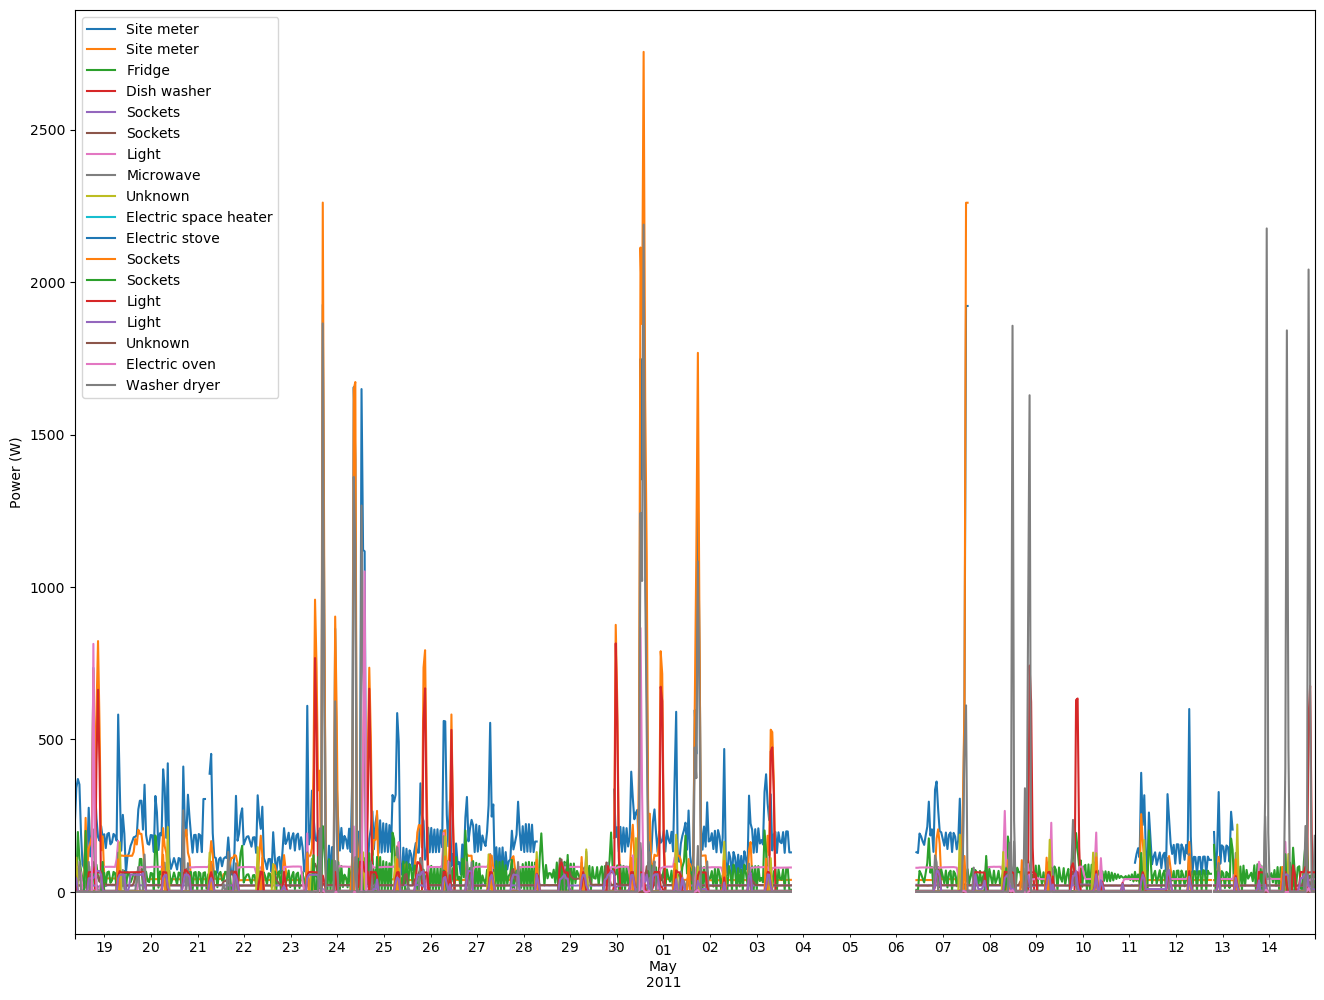

In [5]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 12)
# let us plot the data
train_elec.plot()

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     

/Users/evangelosgeraridis/nilmtk/metergroup.py:720: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  index = pd.date_range(



Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     

/Users/evangelosgeraridis/nilmtk/metergroup.py:720: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  index = pd.date_range(



Done loading data all meters for this chunk.


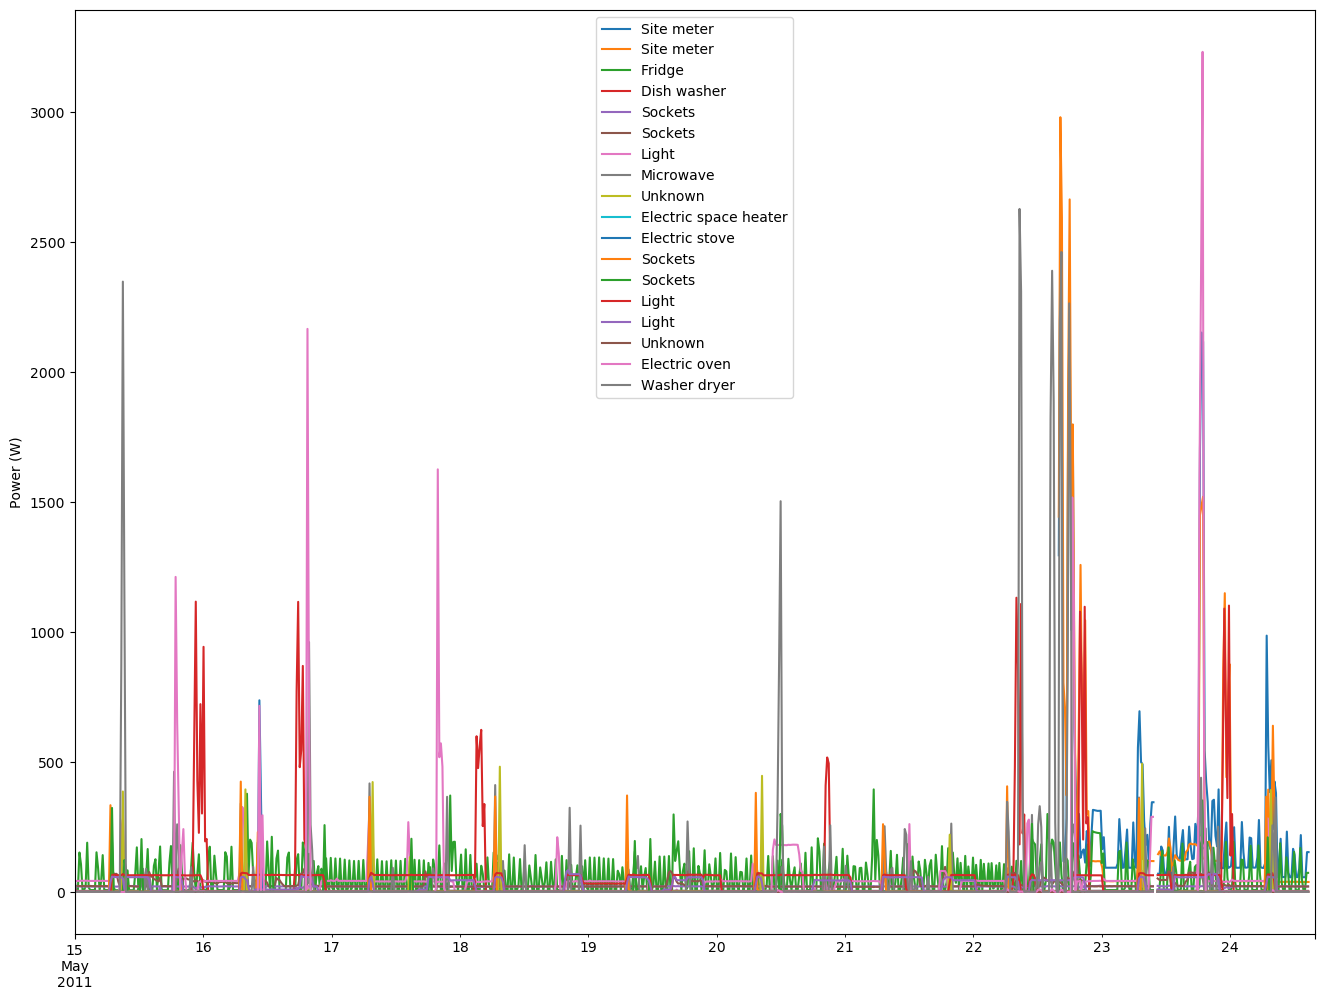

In [6]:
test_elec.plot()

In [7]:
mains = train_elec.mains()
mains_df = next(mains.load())

Loading data for meter ElecMeterID(instance=1, building=1, dataset='REDD')     

/Users/evangelosgeraridis/nilmtk/metergroup.py:720: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  index = pd.date_range(


Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


In [8]:
# let us select the 5 most significant or frequently used appliances in the training data.

top_5_train_elec = train_elec.submeters().select_top_k(k=5)



2/16 ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])

/Users/evangelosgeraridis/nilmtk/results.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(row, verify_integrity=True, sort=False)
/Users/evangelosgeraridis/nilmtk/results.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(new_result._data, sort=False)
/Users/evangelosgeraridis/nilmtk/elecmeter.py:742: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.Series(res[ac_types], index=ac_types)
/Users/evangelosgeraridis/nilmtk/results.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(row, verify_integrity=True, sort=False)
/Users/evangelosgeraridis/nilmtk/

3/16 ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])

/Users/evangelosgeraridis/nilmtk/elecmeter.py:742: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.Series(res[ac_types], index=ac_types)


4/16 ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])

/Users/evangelosgeraridis/nilmtk/results.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(row, verify_integrity=True, sort=False)
/Users/evangelosgeraridis/nilmtk/results.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(new_result._data, sort=False)
/Users/evangelosgeraridis/nilmtk/elecmeter.py:742: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.Series(res[ac_types], index=ac_types)


5/16 ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])

/Users/evangelosgeraridis/nilmtk/results.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(row, verify_integrity=True, sort=False)
/Users/evangelosgeraridis/nilmtk/results.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(new_result._data, sort=False)
/Users/evangelosgeraridis/nilmtk/elecmeter.py:742: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.Series(res[ac_types], index=ac_types)


6/16 ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])

/Users/evangelosgeraridis/nilmtk/results.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(row, verify_integrity=True, sort=False)
/Users/evangelosgeraridis/nilmtk/results.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(new_result._data, sort=False)
/Users/evangelosgeraridis/nilmtk/elecmeter.py:742: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.Series(res[ac_types], index=ac_types)
/Users/evangelosgeraridis/nilmtk/results.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(row, verify_integrity=True, sort=False)
/Users/evangelosgeraridis/nilmtk/

8/16 ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])

/Users/evangelosgeraridis/nilmtk/results.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(row, verify_integrity=True, sort=False)
/Users/evangelosgeraridis/nilmtk/results.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(new_result._data, sort=False)
/Users/evangelosgeraridis/nilmtk/elecmeter.py:742: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.Series(res[ac_types], index=ac_types)


9/16 ElecMeter(instance=14, building=1, dataset='REDD', appliances=[Appliance(type='electric stove', instance=1)])

/Users/evangelosgeraridis/nilmtk/results.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(row, verify_integrity=True, sort=False)
/Users/evangelosgeraridis/nilmtk/results.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(new_result._data, sort=False)
/Users/evangelosgeraridis/nilmtk/elecmeter.py:742: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.Series(res[ac_types], index=ac_types)


10/16 ElecMeter(instance=15, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=3)])

/Users/evangelosgeraridis/nilmtk/results.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(row, verify_integrity=True, sort=False)
/Users/evangelosgeraridis/nilmtk/results.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(new_result._data, sort=False)
/Users/evangelosgeraridis/nilmtk/elecmeter.py:742: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.Series(res[ac_types], index=ac_types)


11/16 ElecMeter(instance=16, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=4)])

/Users/evangelosgeraridis/nilmtk/results.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(row, verify_integrity=True, sort=False)
/Users/evangelosgeraridis/nilmtk/results.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(new_result._data, sort=False)
/Users/evangelosgeraridis/nilmtk/elecmeter.py:742: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.Series(res[ac_types], index=ac_types)


12/16 ElecMeter(instance=17, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=2)])

/Users/evangelosgeraridis/nilmtk/results.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(row, verify_integrity=True, sort=False)
/Users/evangelosgeraridis/nilmtk/results.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(new_result._data, sort=False)
/Users/evangelosgeraridis/nilmtk/elecmeter.py:742: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.Series(res[ac_types], index=ac_types)


13/16 ElecMeter(instance=18, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=3)])

/Users/evangelosgeraridis/nilmtk/results.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(row, verify_integrity=True, sort=False)
/Users/evangelosgeraridis/nilmtk/results.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(new_result._data, sort=False)
/Users/evangelosgeraridis/nilmtk/elecmeter.py:742: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.Series(res[ac_types], index=ac_types)


14/16 ElecMeter(instance=19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])

/Users/evangelosgeraridis/nilmtk/results.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(row, verify_integrity=True, sort=False)
/Users/evangelosgeraridis/nilmtk/results.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(new_result._data, sort=False)
/Users/evangelosgeraridis/nilmtk/elecmeter.py:742: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.Series(res[ac_types], index=ac_types)


15/16 MeterGroup(meters=
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
Calculating total_energy for ElecMeterID(instance=3, building=1, dataset='REDD') ...   

/Users/evangelosgeraridis/nilmtk/results.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(row, verify_integrity=True, sort=False)
/Users/evangelosgeraridis/nilmtk/results.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(new_result._data, sort=False)
/Users/evangelosgeraridis/nilmtk/elecmeter.py:742: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.Series(res[ac_types], index=ac_types)


Calculating total_energy for ElecMeterID(instance=4, building=1, dataset='REDD') ...   

/Users/evangelosgeraridis/nilmtk/results.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(row, verify_integrity=True, sort=False)
/Users/evangelosgeraridis/nilmtk/results.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(new_result._data, sort=False)
/Users/evangelosgeraridis/nilmtk/elecmeter.py:742: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.Series(res[ac_types], index=ac_types)


16/16 MeterGroup(meters=
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=10, building=1, dataset='REDD') ...   

/Users/evangelosgeraridis/nilmtk/results.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(row, verify_integrity=True, sort=False)
/Users/evangelosgeraridis/nilmtk/results.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(new_result._data, sort=False)
/Users/evangelosgeraridis/nilmtk/elecmeter.py:742: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.Series(res[ac_types], index=ac_types)


Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

/Users/evangelosgeraridis/nilmtk/results.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(row, verify_integrity=True, sort=False)
/Users/evangelosgeraridis/nilmtk/results.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(new_result._data, sort=False)
/Users/evangelosgeraridis/nilmtk/elecmeter.py:742: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.Series(res[ac_types], index=ac_types)
/Users/evangelosgeraridis/nilmtk/results.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._data = self._data.append(row, verify_integrity=True, sort=False)
/Users/evangelosgeraridis/nilmtk/

In [9]:
# print these apliances ( 5 most signifficant or freqent)
if top_5_train_elec.meters:
    # Get the names of the top 5 submeters
    top_5_names = [elec.appliances[0].metadata['type'] for elec in top_5_train_elec.meters]

    # Print the names of the top 5 submeters
    for name in top_5_names:
        print(name)
else:
    print("No submeters found.")


fridge
washer dryer
light
sockets
dish washer


In [10]:


from six import iteritems


def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    ground_truths = {}  # Store ground_truths in a list
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=sample_period)):
        chunk_dna = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_dna)
        ground_truths[i]={}

        for meter in test_elec.submeters().meters:
                
            ground_truths[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        ground_truths[i] = pd.DataFrame({l:s.squeeze() for l,s in iteritems(ground_truths[i]) if len(s)}, index=next(iter(ground_truths[i].values())).index).dropna()
        
        

    ground_truths_overall = pd.concat(ground_truths)  # Concatenate the list of ground_truths
    ground_truths_overall.index = ground_truths_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

   
    ground_truths_overall = ground_truths_overall[pred_overall.columns]
    
    #Intersection of index
    ground_truths_index_utc = ground_truths_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    same_index_utc = ground_truths_index_utc.intersection(pred_index_utc)
    
    same_index_local = same_index_utc.tz_convert(timezone)
    ground_truths_overall = ground_truths_overall.loc[same_index_local]
    pred_overall = pred_overall.loc[same_index_local]
    appliance_labels = [j for j in ground_truths_overall.columns.values]
    ground_truths_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return ground_truths_overall, pred_overall

sample_period = 100

preds = {}
print('Using the algorithm Combinatorial Optimisation')

clf = FHMM()
clf.train(top_5_train_elec, sample_period = sample_period)

ground_truths, preds[clf] = predict(clf, test_elec, sample_period, train.metadata['timezone'])

rmse = {}
rmse[clf] = nilmtk.utils.compute_rmse(ground_truths, preds[clf])
rmse_df = pd.DataFrame(rmse)

metrics = ['MSE', 'MAE', 'RMAE', 'R2']
scores = {}

for device in ground_truths.columns:
    scores[device] = {
        'MSE': mean_squared_error(ground_truths[device], preds[clf][device]),
        'MAE': mean_absolute_error(ground_truths[device], preds[clf][device]),
        'RMAE': np.sqrt(mean_squared_error(ground_truths[device], preds[clf][device])) / np.mean(ground_truths[device]),
        'R2': r2_score(ground_truths[device], preds[clf][device])
    }


Using the algorithm Combinatorial Optimisation
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])' with 3 states
Loading data for meter ElecMeterID(instance=10, building=1, dataset='REDD')     

/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/evangelosgeraridis/nilmtk/metergroup.py:720: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  index = pd.date_range(


Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Training model for submeter 'MeterGroup(meters=
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
)' with 3 states


/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])' with 3 states


/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])' with 3 states
Loading data for meter ElecMeterID(instance=1, building=1, dataset='REDD')     

/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/evangelosgeraridis/nilmtk/metergroup.py:720: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  index = pd.date_range(


Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     

/Users/evangelosgeraridis/nilmtk/metergroup.py:720: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  index = pd.date_range(



Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     

/Users/evangelosgeraridis/nilmtk/metergroup.py:720: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  index = pd.date_range(



Done loading data all meters for this chunk.


In [11]:
scores = pd.DataFrame(data = scores)
scores.columns = ['Fridge', 'Washer dryer', 'Light', 'Sockets', 'Dish washer']
rmse_df = pd.DataFrame(rmse[clf])
rmse_df = rmse_df.transpose()
rmse_df.index = ['RMSE']
scores = scores.append(rmse_df)
scores


/var/folders/nc/r0ghbp811_gdhf1gdndmcjt40000gn/T/ipykernel_2773/1659751380.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(rmse_df)


,Fridge,Washer dryer,Light,Sockets,Dish washer
MSE,10961.134688,205193.710933,11593.581572,789.515134,59873.095795
MAE,67.199446,129.388224,71.016341,23.047438,121.506446
RMAE,1.585111,7.104698,3.177497,0.842544,4.613535
R2,-0.336323,-0.452016,-3.861964,-1.136801,-0.287155
RMSE,104.695438,452.983124,107.673495,28.098312,244.689795


In [12]:
preds[clf].columns = ['FRIDGE', 'WASHER DRYER','LIGHT','SOCKETS','DISH WASHER']
preds[clf]

,FRIDGE,WASHER DRYER,LIGHT,SOCKETS,DISH WASHER
2011-05-22 16:03:20-04:00,127.0,6.0,263.0,57.0,273.0
2011-05-22 16:05:00-04:00,191.0,6.0,263.0,57.0,273.0
2011-05-22 16:06:40-04:00,191.0,6.0,263.0,57.0,273.0
2011-05-22 16:08:20-04:00,7.0,0.0,72.0,21.0,273.0
2011-05-22 16:10:00-04:00,191.0,1760.0,263.0,57.0,273.0
...,...,...,...,...,...
2011-05-24 14:28:20-04:00,191.0,0.0,72.0,21.0,0.0
2011-05-24 14:30:00-04:00,191.0,0.0,72.0,21.0,0.0
2011-05-24 14:31:40-04:00,191.0,0.0,72.0,21.0,0.0
2011-05-24 14:33:20-04:00,191.0,0.0,72.0,21.0,0.0


In [13]:


ground_truths.columns = ['FRIDGE', 'WASHER DRYER','LIGHT','SOCKETS','DISH WASHER']

ground_truths # actual values of test set (better column names )

,FRIDGE,WASHER DRYER,LIGHT,SOCKETS,DISH WASHER
2011-05-22 16:03:20-04:00,6.666667,0.000000,1.666667,39.000000,0.000000
2011-05-22 16:05:00-04:00,126.629631,0.000000,1.962963,38.518520,0.444444
2011-05-22 16:06:40-04:00,205.000000,0.000000,2.461539,35.461540,0.307692
2011-05-22 16:08:20-04:00,204.769226,0.000000,2.038461,35.346153,0.192308
2011-05-22 16:10:00-04:00,197.777771,1441.666626,2.000000,38.592594,0.259259
...,...,...,...,...,...
2011-05-24 14:28:20-04:00,198.399994,0.000000,2.000000,20.000000,0.480000
2011-05-24 14:30:00-04:00,196.423080,0.000000,2.115385,20.000000,0.192308
2011-05-24 14:31:40-04:00,195.428574,0.000000,2.000000,20.000000,0.428571
2011-05-24 14:33:20-04:00,195.428574,0.000000,2.000000,20.000000,0.428571


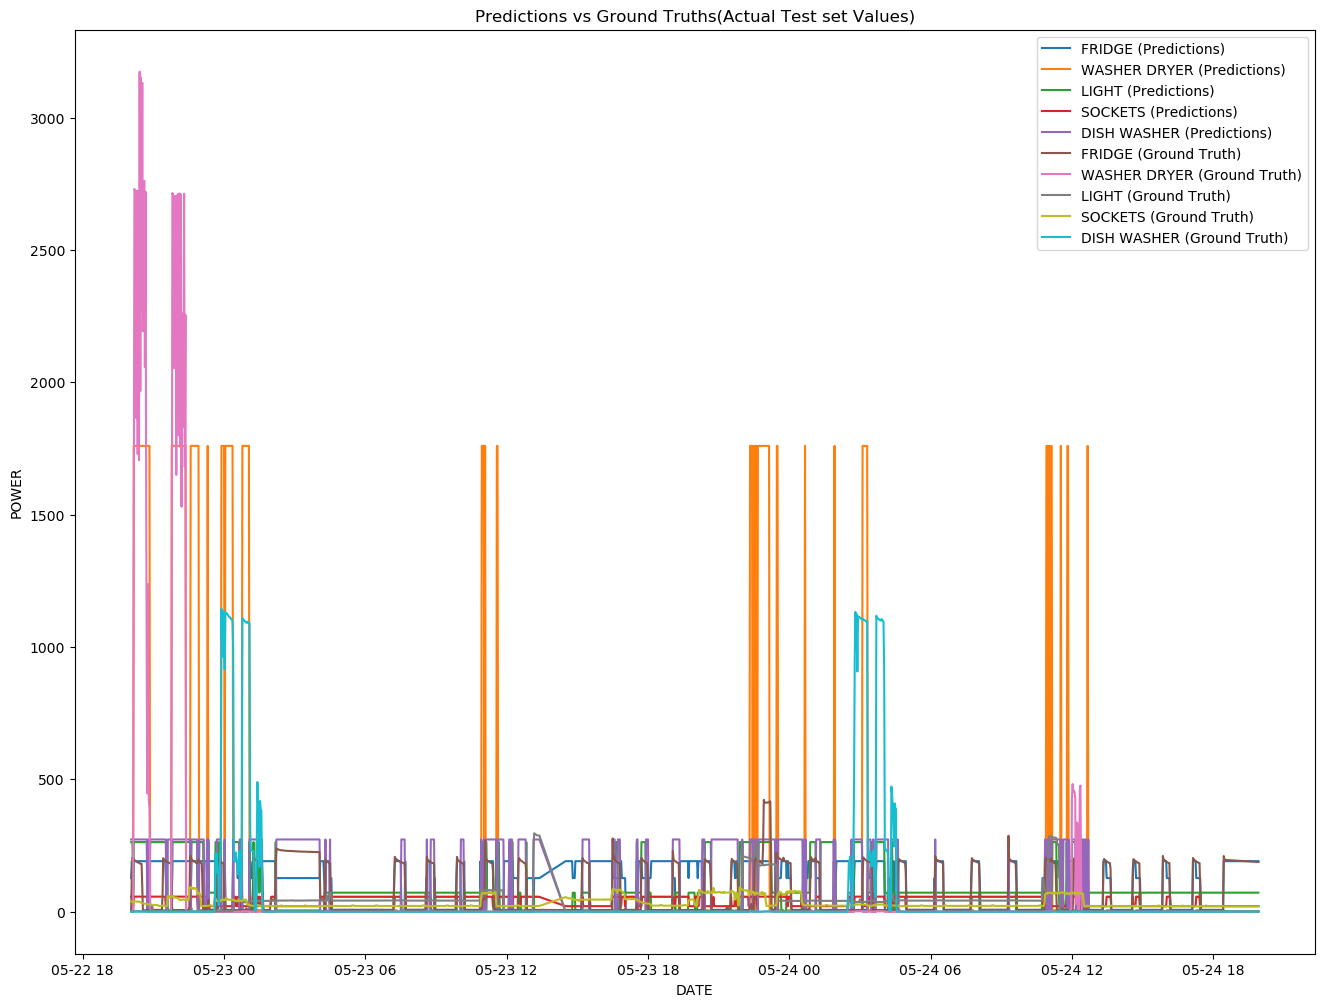

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 12))
pred = preds[clf]
# Plot the predictions dataset
for column in pred.columns:
    ax.plot(pred[column], label=column + ' (Predictions)')

# Plot the ground truths dataset
for column in ground_truths.columns:
    ax.plot(ground_truths[column], label=column + ' (Ground Truth)')

# Set the axis labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('POWER')
ax.set_title('Predictions vs Ground Truths(Actual Test set Values)')

# Add a legend
ax.legend()

# Show the plot
plt.show()

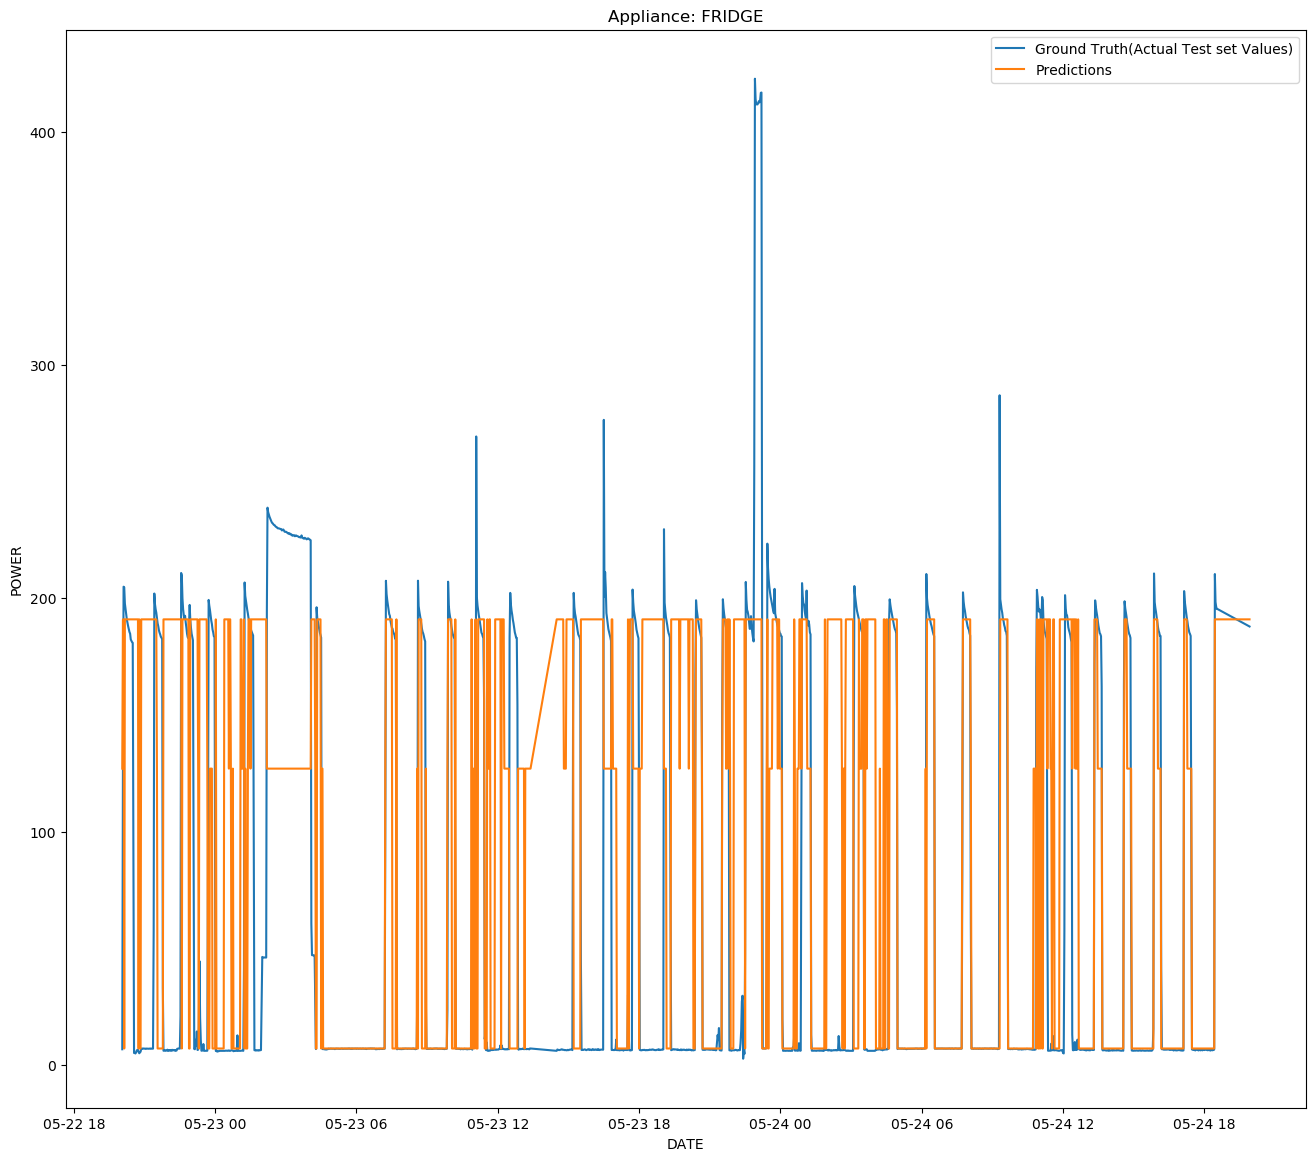

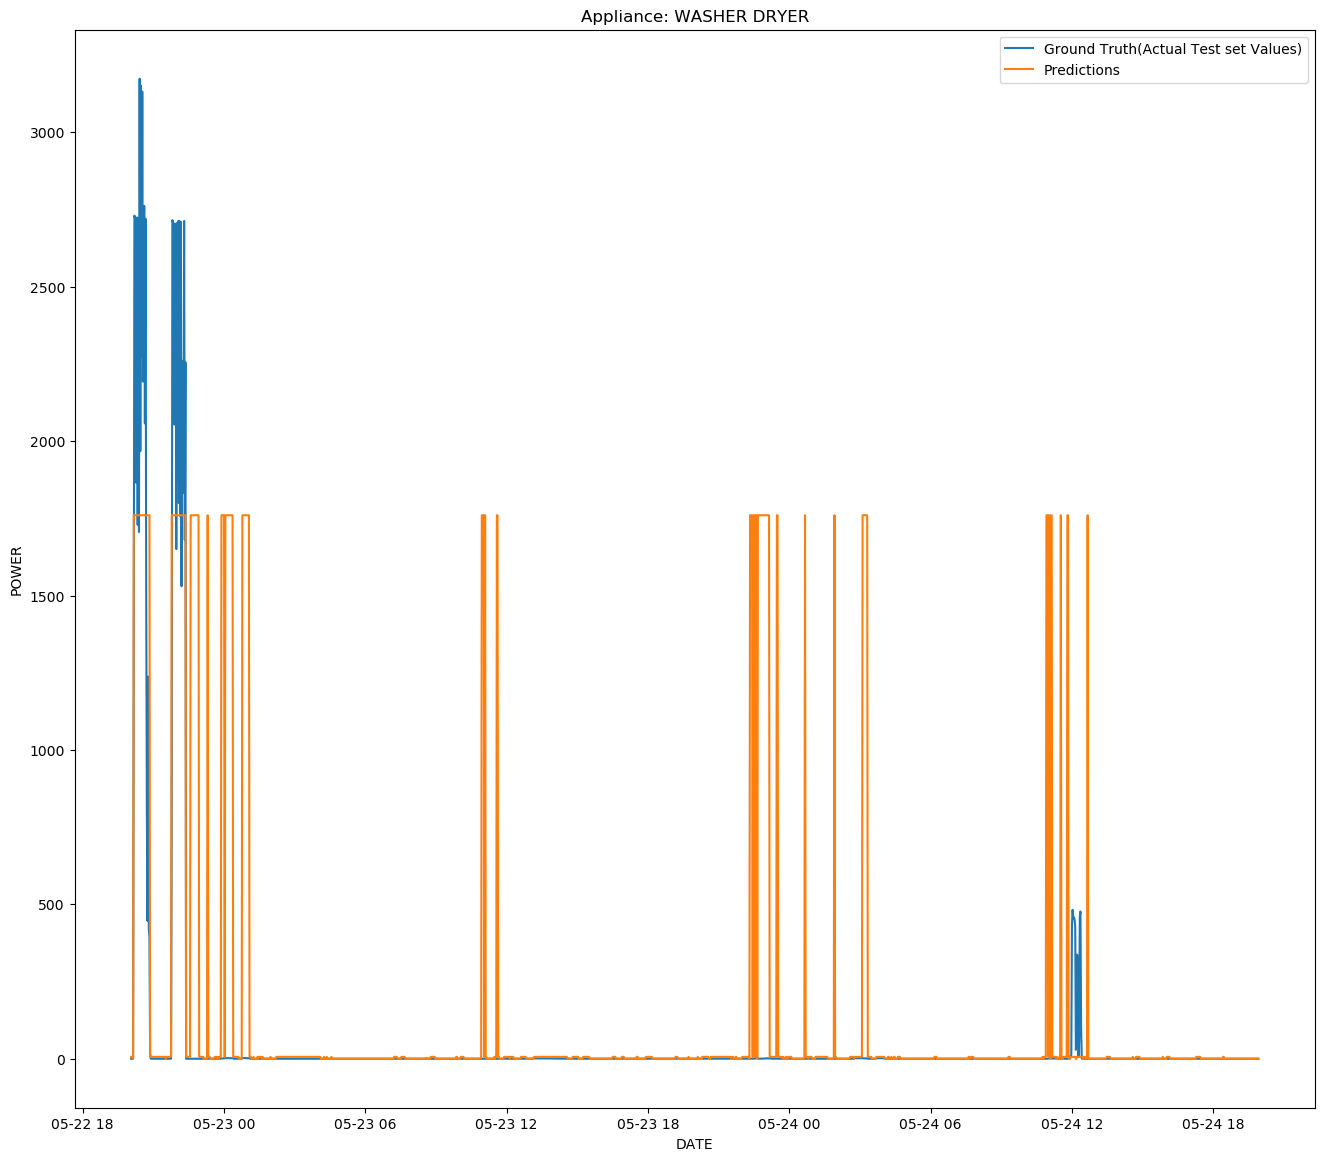

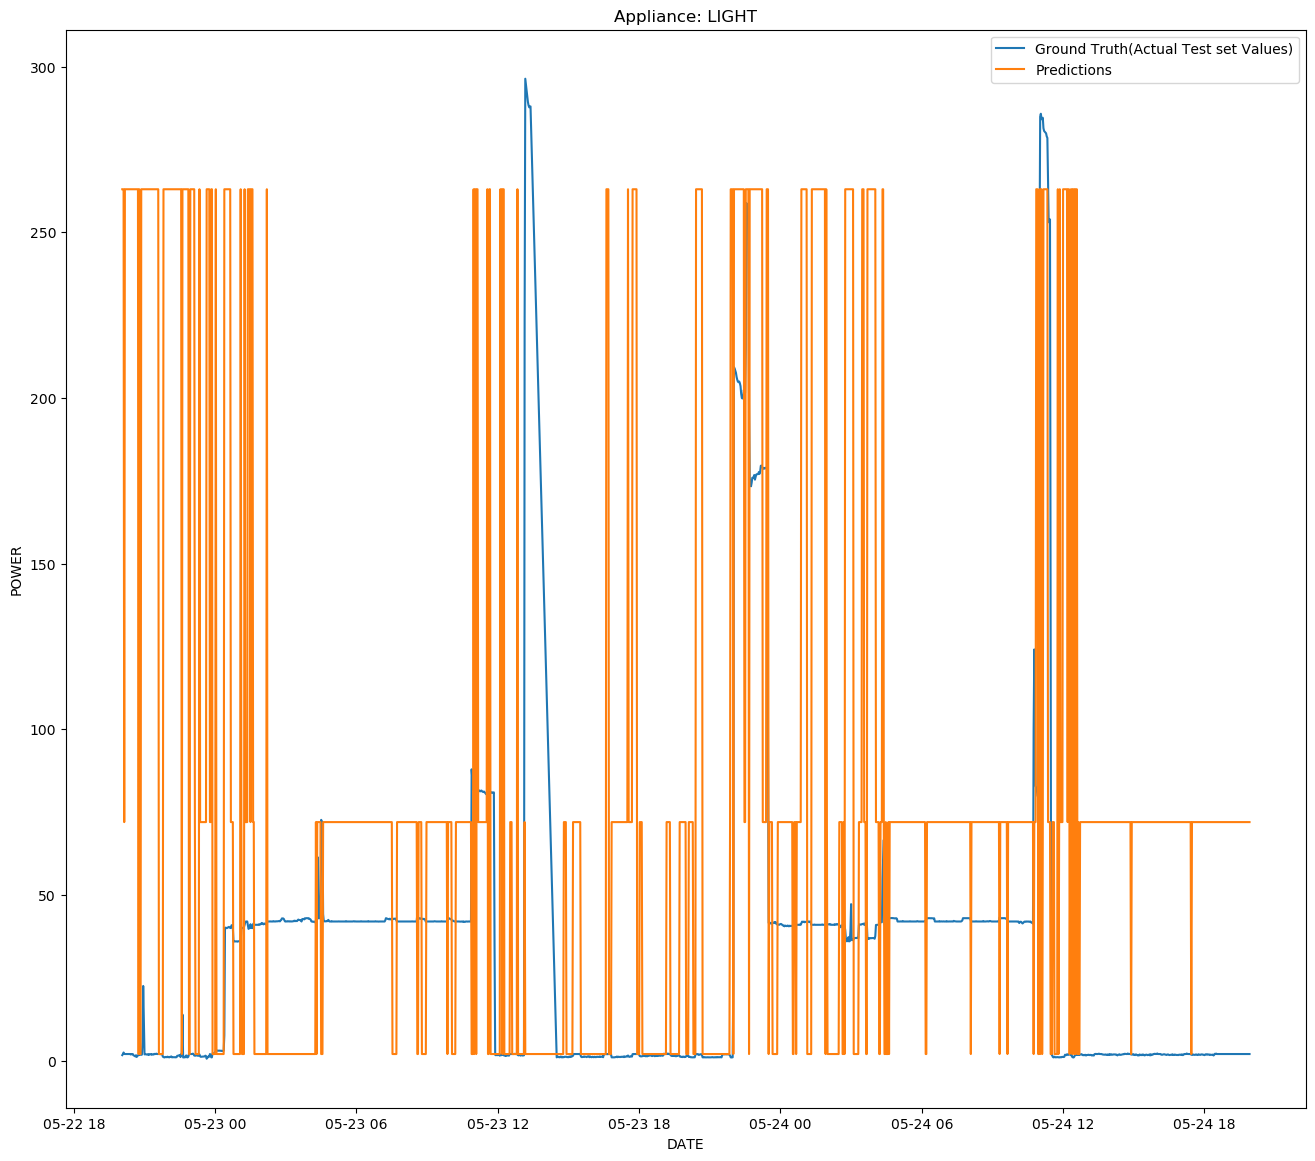

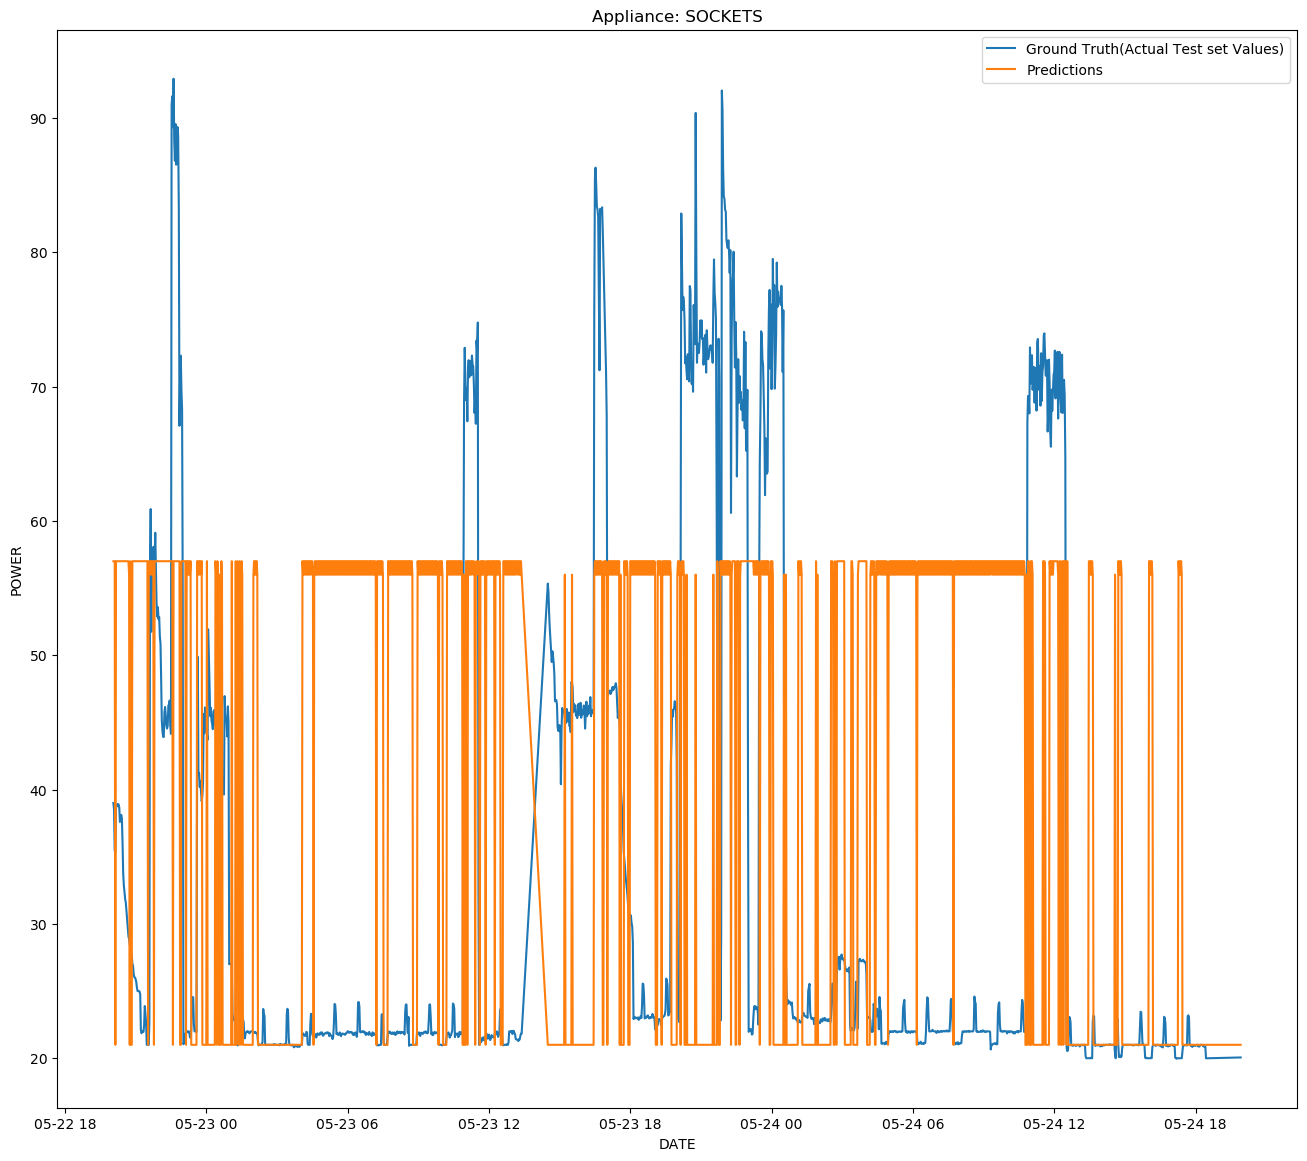

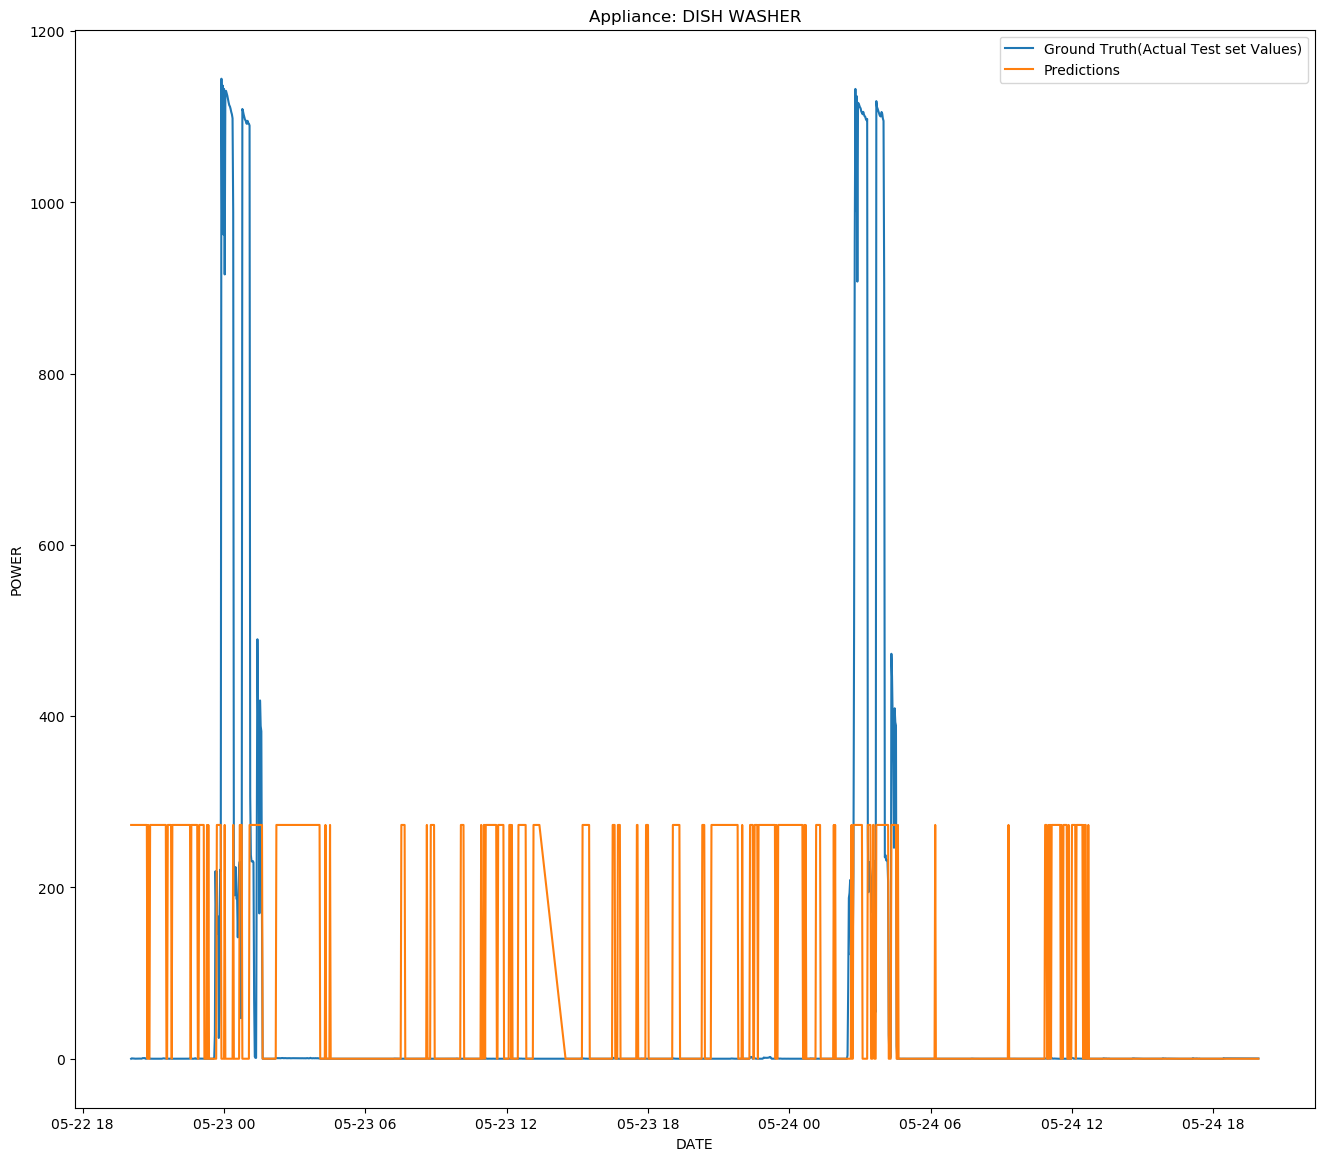

In [16]:
# and since there are 10 lines to observe let us break it 2 each time actul vs pred(or the other way arround)


# Iterate over columns and create individual plots
for column in pred.columns:
    # Create a new figure and axis for each plot
    fig, ax = plt.subplots(figsize=(16, 14))
    
    # Plot the ground truths
    ax.plot(ground_truths[column], label='Ground Truth(Actual Test set Values)')
    
    # Plot the predictions
    ax.plot(pred[column], label='Predictions')
    
    # Set the axis labels and title
    ax.set_xlabel('DATE')
    ax.set_ylabel('POWER')
    ax.set_title('Appliance: ' + column)
    
    # Add a legend
    ax.legend()
    
    # Show the plot
    plt.show()
